In [1]:
import xarray as xr
import datetime
import numpy as np

In [2]:
#we want to run our model for different dates
t0_i = datetime.datetime(2018,9,9,0)
t0_f = datetime.datetime(2018,9,12,18)
delta_h = 6
# number of forecast steps
num_steps = 4 * 15 # 6h intervals

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

In [3]:
def load_data(var, init_times):
    var_inits = []
    for t0 in init_times:
        yyyymmddhh = t0.strftime('%Y%m%d%H')    
        file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_{yyyymmddhh}.nc'
        ds = xr.open_dataset(file)[var]
        var_inits.append(ds)
    merged_dataset = xr.concat(var_inits, dim='init_time')
    return merged_dataset.assign_coords(init_time=init_times)

In [4]:
#load data

msl = load_data('msl',init_times)
v100 = load_data('v100m', init_times)
u100 = load_data('u100m', init_times)
tcwv = load_data('tcwv', init_times)
    

In [5]:
#reanalysis data:
dir = '/home/bernatj/Data/my_data/era5/6hourly/mslp/mslp-era5-6-hourly-025-2018.nc'
msl_era5 = xr.open_dataset(dir).msl
msl_era5 = msl_era5.rename({'latitude' : 'lat', 'longitude' : 'lon'}) 

dir = '/home/bernatj/Data/my_data/era5/6hourly/v100m/v100m-era5-6-hourly-025-2018.nc'
v100_era5 = xr.open_dataset(dir).v100
v100_era5 = v100_era5.rename({'latitude' : 'lat', 'longitude' : 'lon'}) 

dir = '/home/bernatj/Data/my_data/era5/6hourly/u100m/u100m-era5-6-hourly-025-2018.nc'
u100_era5 = xr.open_dataset(dir).u100
u100_era5 = u100_era5.rename({'latitude' : 'lat', 'longitude' : 'lon'}) 

dir = '/home/bernatj/Data/my_data/era5/6hourly/tcwv/tcwv-era5-6-hourly-025-2018.nc'
tcwv_era5 = xr.open_dataset(dir).tcwv
tcwv_era5 = tcwv_era5.rename({'latitude' : 'lat', 'longitude' : 'lon'}) 

In [6]:
import numpy as np
from scipy.ndimage import minimum_filter
from scipy.spatial.distance import cdist

def calculate_trajectory(data, latitudes, longitudes, threshold_distance=10, threshold_data_value=100500, neighborhood_size=200):
    # Create an empty list to store minima indices for each timestep
    minima_indices_per_timestep = []
    minima_value_per_timestep = []

    # Iterate over each timestep
    for timestep_data in data:
        # Check for missing values in the data
        if np.any(np.isnan(timestep_data)):
            continue  # Skip this timestep if it contains missing values
        
        # Apply minimum filtering to find local minima for the current timestep
        local_minima = minimum_filter(timestep_data, size=neighborhood_size)

        #the smallest local minima:
        local_minima = np.min(local_minima)

        # Find indices where the original data is equal to the filtered result
        minima_indices = np.where(timestep_data == local_minima)

        # Append minima indices for the current timestep to the list
        minima_indices_per_timestep.append(minima_indices)
        minima_value_per_timestep.append(local_minima)

    # Initialize lists to store the selected minima
    selected_latitudes = []
    selected_longitudes = []
    minima =[]

    # Iterate over each timestep
    for i, indices in enumerate(minima_indices_per_timestep):
        # Convert indices to coordinates
        minima_coordinates = list(zip(latitudes[indices[0]], longitudes[indices[1]]))

        # Calculate distances from the previous minimum
        if selected_latitudes and selected_longitudes:  # Check if there's a previous minimum
            prev_minimum = (selected_latitudes[-1], selected_longitudes[-1])
            distances = cdist([prev_minimum], minima_coordinates).flatten()
        else:
            distances = np.full(len(minima_coordinates), np.inf)  # Set distances to infinity if no previous minimum

        # Find the index of the minimum distance
        min_distance_index = np.argmin(distances)

        # Check if the minimum distance exceeds the threshold or if the data value exceeds the threshold
        if i > 0 and (np.min(distances) > threshold_distance or minima_value_per_timestep[min_distance_index] > threshold_data_value):
            print(f'break: distance {np.min(distances)}, threshold: {minima_value_per_timestep[min_distance_index]}')
            break
        else:
            # Select the closest minimum
            selected_latitudes.append(minima_coordinates[min_distance_index][0])
            selected_longitudes.append(minima_coordinates[min_distance_index][1])
            minima.append(minima_value_per_timestep[i])

    return selected_latitudes, selected_longitudes, minima


In [70]:
#region and time to calculate the trajectories
lat_slice=slice(36,22)
lon_slice=slice(275,320)
time_slice=slice('2018-09-09', '2018-09-15')

# Assuming data is your 2D array
msl_area = msl.sel(lat=lat_slice,lon=lon_slice, time=time_slice)
latitudes = msl_area.lat
longitudes = msl_area.lon

#same for windspeed
u100_area = u100.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()
v100_area = v100.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()

lat_track_list = []
lon_track_list = []
min_track_list = []

for init in init_times:
    print(init)
    data = msl_area.sel(init_time=init).data
    lat_track, lon_track, min_track = calculate_trajectory(data, latitudes, longitudes, threshold_distance=10, threshold_data_value=102500, neighborhood_size=100)
    lat_track_list.append(lat_track)
    lon_track_list.append(lon_track) 
    min_track_list.append(min_track) 

2018-09-09 00:00:00
break: distance 41.35894703688671, threshold: 100441.0625
2018-09-09 06:00:00
break: distance 41.6473288459176, threshold: 100242.125
2018-09-09 12:00:00
break: distance 39.72798132299199, threshold: 100284.25
2018-09-09 18:00:00
break: distance 39.67760703469906, threshold: 99897.5625
2018-09-10 00:00:00
break: distance 40.37635446644484, threshold: 99957.8125
2018-09-10 06:00:00
break: distance 40.590947266601205, threshold: 99859.875
2018-09-10 12:00:00
break: distance 40.288025516274686, threshold: 99693.375
2018-09-10 18:00:00
2018-09-11 00:00:00
2018-09-11 06:00:00
2018-09-11 12:00:00
2018-09-11 18:00:00
2018-09-12 00:00:00
2018-09-12 06:00:00
2018-09-12 12:00:00
2018-09-12 18:00:00


In [8]:
#same for era5
lat_slice=slice(36,22)
lon_slice=slice(275,320)
time_slice=slice('2018-09-09', '2018-09-15')

# Assuming data is your 2D array
msl_era5_area = msl_era5.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()

#same for windspeed
u100_era5_area = u100_era5.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()
v100_era5_area = v100_era5.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()

latitudes = msl_era5_area.lat.values
longitudes = msl_era5_area.lon.values

print(latitudes)
lat_track_era5, lon_track_era5, min_track_era5 = calculate_trajectory(msl_era5_area.data, latitudes, longitudes, threshold_distance=10, threshold_data_value=102500, neighborhood_size=100)

[36.   35.75 35.5  35.25 35.   34.75 34.5  34.25 34.   33.75 33.5  33.25
 33.   32.75 32.5  32.25 32.   31.75 31.5  31.25 31.   30.75 30.5  30.25
 30.   29.75 29.5  29.25 29.   28.75 28.5  28.25 28.   27.75 27.5  27.25
 27.   26.75 26.5  26.25 26.   25.75 25.5  25.25 25.   24.75 24.5  24.25
 24.   23.75 23.5  23.25 23.   22.75 22.5  22.25 22.  ]


In [ ]:
# Assuming data is your 2D array
msl_area = msl_era5.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()

#same for windspeed
u100_area = u100_era5.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()
v100_area = v100_era5.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()

In [10]:
msl_plot = msl.load()

/home/bernatj/miniconda3/envs/bayesevt_ai/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'lw'
  result = super().contour(*args, **kwargs)


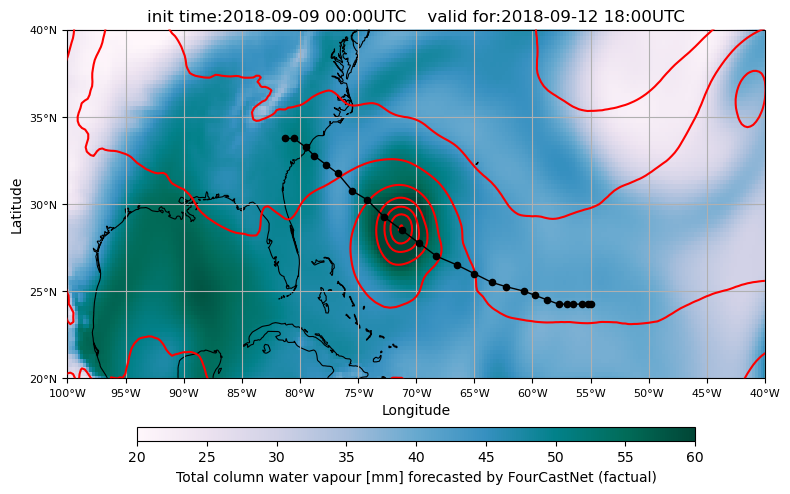

<Figure size 800x600 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

init=0
t=15


# Create subplots with shared y-axis and manually share x-axis
f, ax = plt.subplots(1, 1, figsize=(9,7), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Assuming Natl is your xarray dataset containing latitude and longitude coordinates
# minima_indices is the indices of the minima obtained earlier
latitudes = msl['lat'].values
longitudes = msl['lon'].values

# Plot the trajectory in latitude-longitude coordinates
plt.figure(figsize=(8, 6))

# Define a colormap that starts from blue and gradually moves towards red
cmap = plt.get_cmap('Blues_r')

# Normalize initialization times to range from 0 to 1
norm = plt.Normalize(0, len(init_times))

ax.set_aspect(1.5)
ax.coastlines(lw=0.8, color='k')  
contours = ax.contour(longitudes, latitudes, msl_plot[init,t]*0.01, colors='r', lw=0.8, levels=np.arange(980,1030,4), zorder=10) 
#labels = plt.clabel(contours, inline=True, fmt='%1i', colors='g', fontsize=6,  inline_spacing=10)
#h = ax.contourf(longitudes, latitudes, wind_speed_plot[init,t], cmap='CMRmap_r', zorder=1, levels=np.arange(0,30,2), extend='max') 
h = ax.pcolormesh(longitudes, latitudes, tcwv[init,t], cmap='PuBuGn', vmax=60, vmin=20, zorder=1)

nLons = np.arange(-180, 180, 5)
nLats = np.arange(20, 41, 5)
ax.set_xticks(nLons, crs=ccrs.PlateCarree())
ax.set_yticks(nLats, crs=ccrs.PlateCarree())
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylim([20, 40])
ax.set_xlim([-100, -40])


# format the ticks as e.g 60°W
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('init time:' + msl.init_time.dt.strftime('%Y-%m-%d %H:00UTC').values[init] + '    valid for:' + msl.time.dt.strftime('%Y-%m-%d %H:00UTC').values[t])
ax.grid(True)

# Extract latitude and longitude values corresponding to minima_indices
ax.scatter(lon_track_list[init], lat_track_list[init], marker='o', s=20, color='k', transform=ccrs.PlateCarree(), zorder=100)
ax.plot(lon_track_list[init], lat_track_list[init], lw=1.0, color='k', transform=ccrs.PlateCarree(), zorder=100)


#cbar = plt.colorbar(h, ax=ax, label='Wind Speed [m/s] at 100 meters forecasted by FourCastNet (factual)', pad=0.09, orientation='horizontal', shrink=0.8, aspect=40)
cbar = plt.colorbar(h, ax=ax, label='Total column water vapour [mm] forecasted by FourCastNet (factual)', pad=0.09, orientation='horizontal', shrink=0.8, aspect=40)
#f.savefig(f'plot_hurricane_Florence_2018_init_{init}_t={t}.png')


In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np

# Assuming you have initialized variables init_times, lon_track_list, lat_track_list, msl, and wind_speed
# Define the range of initialization times and times
init_range = [0,4,8,12]
time_range = [12,16,20,24]

# Define the size of the panel
num_init = len(init_range)
num_time = len(time_range)
fig, axes = plt.subplots(num_init, num_time, sharex=True, sharey=True, figsize=(12, 10), subplot_kw=dict(projection=ccrs.PlateCarree()), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# Flatten the axes array if only one init and/or time
if num_init == 1:
    axes = axes.reshape(1, -1)
if num_time == 1:
    axes = axes.reshape(-1, 1)

# Loop over initialization times and times
for i, init in enumerate(init_range):
    for j, t in enumerate(time_range):
        ax = axes[i, j]        
        # Plot your data on each subplot
        ax.set_aspect(1.5)
        ax.coastlines(lw=0.8, color='k')  

        contours = ax.contour(msl['lon'], msl['lat'], msl_plot[init, t]*0.01, colors='g', linewidths=1.0, levels=np.arange(980, 1030, 4), zorder=10) 
        #h = ax.contourf(msl['lon'], msl['lat'], wind_speed_plot[init, t], cmap='CMRmap_r', zorder=1, levels=np.arange(0, 30, 2), extend='max') 
        h = ax.pcolormesh(msl['lon'], msl['lat'], tcwv[init, t], cmap='PuBuGn', zorder=1, vmin=20, vmax=70,)

        ax.scatter(lon_track_list[init], lat_track_list[init], marker='o', s=10, color='b', transform=ccrs.PlateCarree(), zorder=100)
        ax.scatter(lon_track_era5, lat_track_era5, marker='x', s=10, color='k', transform=ccrs.PlateCarree(), zorder=100)
        ax.plot(lon_track_list[init], lat_track_list[init], lw=1.0, color='b', transform=ccrs.PlateCarree(), zorder=100)
        ax.plot(lon_track_era5, lat_track_era5, lw=1.0, color='k', transform=ccrs.PlateCarree(), zorder=100)

        if j==0:
            ax.set_yticks(np.arange(20, 41, 5), crs=ccrs.PlateCarree())
            ax.set_ylabel(f'Init: {msl.init_time.dt.strftime("%Y-%m-%d %HZ").values[init]}', fontsize=9)
        if i == len(init_range)-1:
            ax.set_xticks(np.arange(-180, 180, 10), crs=ccrs.PlateCarree())

        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.set_ylim([22, 36])
        ax.set_xlim([-90, -50])
        
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())


        if i==0:
            ax.set_title(f'valid time: {msl.time.dt.strftime("%Y-%m-%d %HZ").values[t]}', fontsize=9)
        

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the color bar
cbar = plt.colorbar(h, ax=axes, label='Total column water vapour [mm] forecasted by FourCastNet (factual)', pad=0.08, orientation='horizontal', shrink=0.8, aspect=50)

# Save the figure
plt.savefig(f'plot_hurricane_florian_2018_panel_factual_tcwv.pdf', bbox_inches='tight')
plt.savefig(f'plot_hurricane_florian_2018_panel_factual_tcwv.png')
plt.show()


/tmp/ipykernel_2708032/2948824521.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


KeyboardInterrupt: 

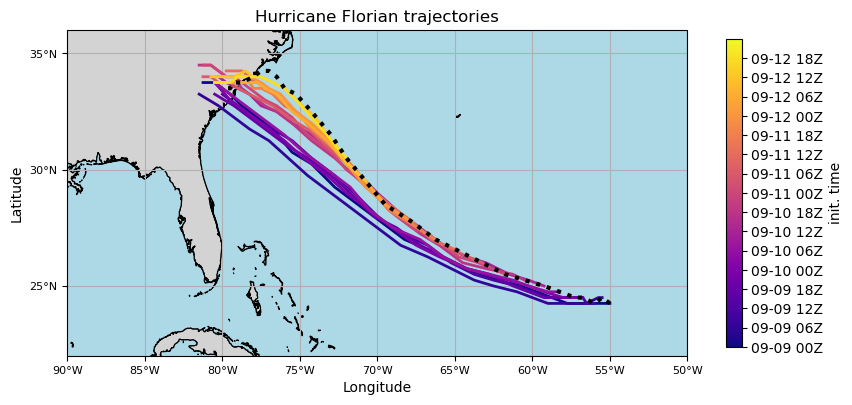

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Create subplots with shared y-axis and manually share x-axis
f, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Assuming Natl is your xarray dataset containing latitude and longitude coordinates
# minima_indices is the indices of the minima obtained earlier
latitudes = msl['lat'].values
longitudes = msl['lon'].values

ax.set_aspect(1.5)
ax.coastlines(lw=0.8, color='k')  
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Fill land area
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')  # Fill ocean area


nLons = np.arange(-180, 180, 5)
nLats = np.arange(20, 41, 5)
ax.set_xticks(nLons, crs=ccrs.PlateCarree())
ax.set_yticks(nLats, crs=ccrs.PlateCarree())
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylim([22, 36])
ax.set_xlim([-90, -50])

# format the ticks as e.g 60°W
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Hurricane Florian trajectories')
ax.grid(True)

# Define a colormap that starts from blue and gradually moves towards red
cmap = plt.get_cmap('plasma')

# Normalize initialization times to range from 0 to 1
norm = plt.Normalize(0, len(init_times))

for i,_ in enumerate(lat_track_list):
    # Extract latitude and longitude values corresponding to minima_indices
    color = cmap(norm(i))
    ax.plot(lon_track_list[i], lat_track_list[i], lw=2.0, color=color, transform=ccrs.PlateCarree(), zorder=100)

ax.plot(lon_track_era5, lat_track_era5, lw=3.0, color='k', ls=':', transform=ccrs.PlateCarree(), zorder=101)


# Create a colorbar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="init. time", shrink=0.4)
cbar.set_ticks(np.arange(0, len(init_times)))

# Format the init_times to show only MM-DD HHUTC
init_time_labels = [time.strftime('%m-%d %HZ') for time in init_times]
cbar.set_ticklabels(init_time_labels)


f.savefig(f'Hurricane_Florence_2018_Tracks_different_inits_factual.pdf')
f.savefig(f'Hurricane_Florence_2018_Tracks_different_inits_factual.png')



In [ ]:
for i in range(0,10):
    print(min_track_list[i])

[100441.06, 100317.31, 100468.63, 100329.25, 100383.15, 100222.04, 100277.46, 100116.77, 100054.734, 99873.02, 99831.94, 99683.29, 99661.05, 99583.89, 99578.7, 99577.984, 99574.836, 99664.89, 99654.57, 99649.945, 99485.74, 99460.65, 99716.03, 100061.2, 100420.08]
[100242.125, 100385.2, 100333.23, 100388.484, 100196.484, 100209.016, 100067.19, 99978.23, 99780.27, 99738.03, 99580.164, 99497.09, 99437.64, 99399.74, 99360.734, 99386.23, 99432.484, 99458.83, 99440.61, 99308.06, 99280.516, 99604.07, 100045.52]
[100284.25, 100147.93, 100299.68, 100211.26, 100239.72, 100105.625, 100012.57, 99790.875, 99769.61, 99579.06, 99562.84, 99446.08, 99480.01, 99460.484, 99496.76, 99509.61, 99546.52, 99494.62, 99339.164, 99394.1, 99714.53]
[99897.56, 100057.97, 100189.195, 100204.41, 100043.23, 99962.13, 99713.32, 99647.46, 99449.22, 99408.74, 99267.66, 99289.766, 99237.41, 99265.96, 99282.375, 99340.73, 99275.31, 99136.08, 99301.336, 99706.44]
[99957.81, 100021.5, 100072.65, 99919.414, 99821.38, 99556.7

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


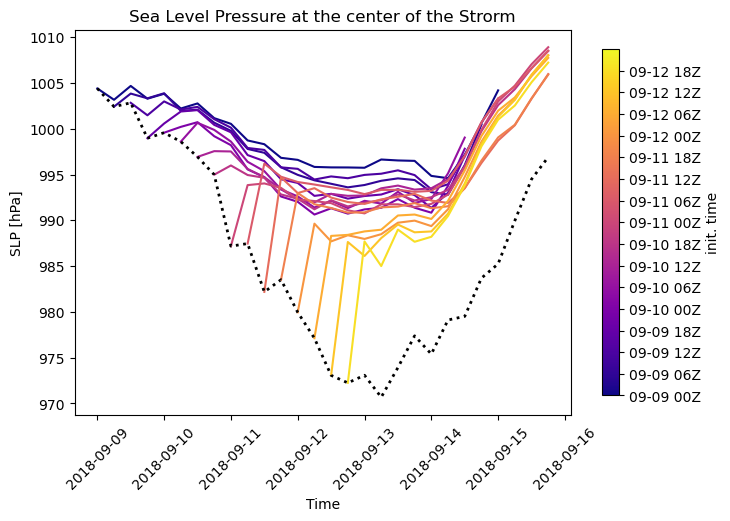

In [13]:
#evolution of pressure at along the track
f, ax = plt.subplots(1, 1, figsize=(8,5))

# Define a colormap that starts from blue and gradually moves towards red
cmap = plt.get_cmap('plasma')

# Normalize initialization times to range from 0 to 1
norm = plt.Normalize(0, len(init_times))

for i,_ in enumerate(lat_track_list):
    print(i)
    # Extract latitude and longitude values corresponding to minima_indices
    color = cmap(norm(i))
    plt.plot(msl.time.values[i:i+len(min_track_list[i])], np.array(min_track_list[i])*0.01 , color=color)

plt.plot(msl_era5_area.time.values[0:len(min_track_era5)], np.array(min_track_era5)*0.01, color='k', lw=2, ls=':')

# Create a colorbar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="init. time", shrink=0.9)
cbar.set_ticks(np.arange(0, len(init_times)))

# Format the init_times to show only MM-DD HHUTC
init_time_labels = [time.strftime('%m-%d %HZ') for time in init_times]
cbar.set_ticklabels(init_time_labels)

plt.xticks(rotation=45)


# Add labels and title
plt.xlabel('Time')
plt.ylabel('SLP [hPa]')
plt.title('Sea Level Pressure at the center of the Strorm')

# Show the plot
plt.show()

f.savefig(f'Hurricane_Florence_2018_SLP_Minimum_evolution_different inits.pdf')


# Evaluation of the storm radius

In [14]:
lon_track_era5[10]

295.25

In [15]:
msl_era5

<xarray.DataArray 'msl' (time: 1460, lat: 721, lon: 1440)> Size: 6GB
[1515830400 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 12kB 2018-01-01 ... 2018-12-31T18:00:00
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_mean_sea_level

In [16]:
msl_era5_area[15].time

<xarray.DataArray 'time' ()> Size: 8B
array('2018-09-12T18:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2018-09-12T18:00:00
Attributes:
    long_name:  time

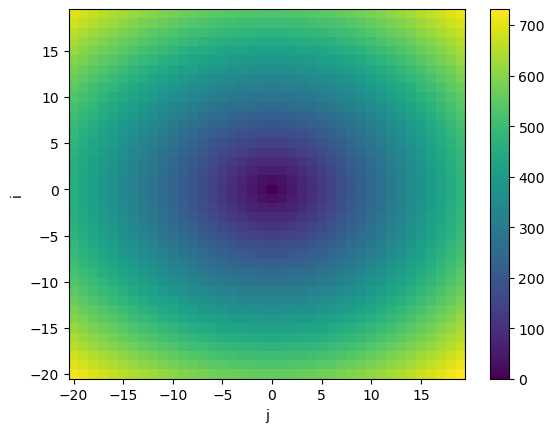

In [17]:
#for one istance of time we identify the grid cell of the center of the hurricane.

t=15

lat_idx = np.where(msl_era5_area.lat == lat_track_era5[t])[0][0]
lon_idx = np.where(msl_era5_area.lon == lon_track_era5[t])[0][0]
Re =6370 #km
res=0.25*np.pi/180.

incr_lat = np.arange(-20,20)
incr_lon = np.arange(-20,20)
lats = msl_era5_area.lat

radius = xr.DataArray(dims=('i', 'j'), coords={'i' : incr_lon ,'j' : incr_lat  })
msl_storm = xr.DataArray(dims=('i', 'j'), coords={'i' : incr_lon ,'j' : incr_lat  })
wsp_storm = xr.DataArray(dims=('i', 'j'), coords={'i' : incr_lon ,'j' : incr_lat  })

for j,i_lat in enumerate(incr_lat):
    for i,i_lon in enumerate(incr_lon):
        lat_i = lat_idx + i_lat
        lon_i = lon_idx + i_lon
        radius[i,j] = np.sqrt((i_lon*res*Re)**2 + (i_lat*res*np.cos(lats[lat_i]*np.pi/180.)*Re)**2)
        msl_storm[i,j] = msl_era5_area[t,lat_i,lon_i]
        wsp_storm[i,j] = np.sqrt(u100_era5_area[t,lat_i,lon_i]**2 + v100_era5_area[t,lat_i,lon_i]**2)


radius.plot()




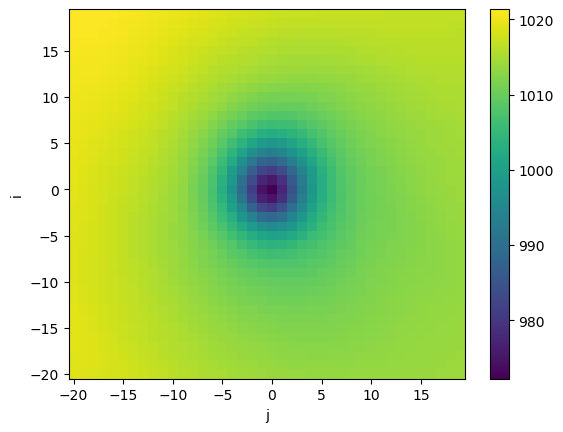

In [18]:
(msl_storm*0.01).plot()

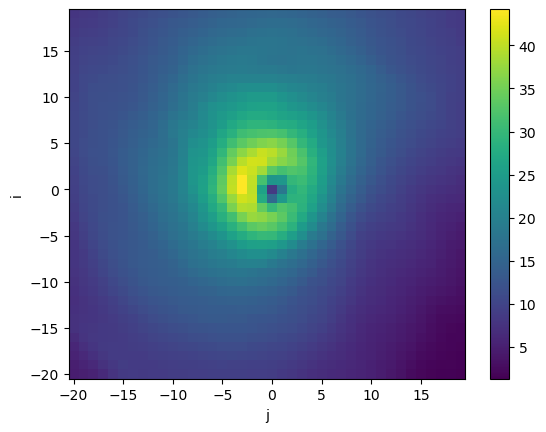

In [19]:
wsp_storm.plot()

In [62]:
wsp_storm_radius

<xarray.DataArray (radius: 40)> Size: 320B
array([ 8.57147408,         nan, 23.8760184 , 33.80148768, 35.56801741,
       35.95706093, 34.06215382, 30.35481373, 27.56803563, 25.0662618 ,
       22.82132836, 20.85294644, 19.41711979, 18.13895035, 17.07536148,
       16.08040381, 15.32897474, 14.34740184, 13.3121277 , 13.37804629,
       12.97602178, 12.09589977, 11.53706558, 11.64999373, 10.66960821,
        9.92239534, 10.52790289,  9.95320583,  9.19873923,  8.73434032,
        8.08729812,  7.63938337,  7.29838199,  6.71136649,  6.32826911,
        5.58219921,  4.42426394,  2.98337001,         nan,         nan])
Coordinates:
  * radius   (radius) int64 320B 0 20 40 60 80 100 ... 680 700 720 740 760 780

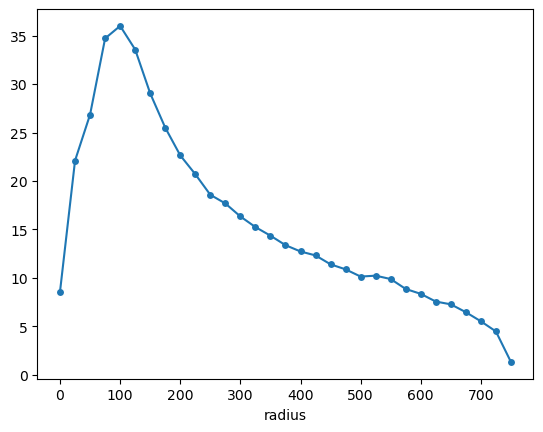

In [69]:
#transform to radius instead of (i,j)

incr_radius = np.arange(0,800,25)

msl_storm_radius = xr.DataArray(dims=['radius'], coords={'radius' : incr_radius})
wsp_storm_radius = xr.DataArray(dims=['radius'], coords={'radius' : incr_radius})

for i,r in enumerate(incr_radius):
    if i>0:
        bool = ((radius <= r) & (radius > incr_radius[i-1]))
    else:
        bool = (radius <= r)

    msl_nans = (msl_storm * bool)
    msl_nans = msl_nans.where(msl_nans != 0, np.nan)
    msl_storm_radius.loc[{'radius' : r}] = msl_nans.mean(['i','j'])

    wsp_nans = (wsp_storm * bool)
    wsp_nans = wsp_nans.where(wsp_nans != 0, np.nan)

    wsp_storm_radius.loc[{'radius' : r}] = wsp_nans.mean(['i','j'])

wsp_storm_radius.plot.scatter()
wsp_storm_radius.plot()

In [73]:
#for one istance of time we identify the grid cell of the center of the hurricane.

t=15

lat_idx = np.where(msl_area.lat == lat_track_list[0][t])[0][0]
lon_idx = np.where(msl_area.lon == lon_track_list[0][t])[0][0]
Re =6370 #km
res=0.25*np.pi/180.

incr_lat = np.arange(-20,20)
incr_lon = np.arange(-20,20)
lats = msl_area.lat

radius = xr.DataArray(dims=('i', 'j'), coords={'i' : incr_lon ,'j' : incr_lat  })
msl_storm_ai = xr.DataArray(dims=('i', 'j'), coords={'i' : incr_lon ,'j' : incr_lat  })
wsp_storm_ai = xr.DataArray(dims=('i', 'j'), coords={'i' : incr_lon ,'j' : incr_lat  })

for j,i_lat in enumerate(incr_lat):
    for i,i_lon in enumerate(incr_lon):
        lat_i = lat_idx + i_lat
        lon_i = lon_idx + i_lon
        radius[i,j] = np.sqrt((i_lon*res*Re)**2 + (i_lat*res*np.cos(lats[lat_i]*np.pi/180.)*Re)**2)
        msl_storm_ai[i,j] = msl_area[0,t,lat_i,lon_i]
        wsp_storm_ai[i,j] = np.sqrt(u100_area[0,t,lat_i,lon_i]**2 + v100_area[0,t,lat_i,lon_i]**2)



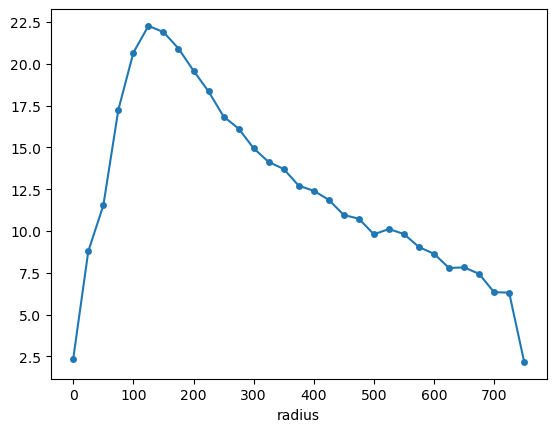

In [76]:
#transform to radius instead of (i,j)

incr_radius = np.arange(0,900,25)

msl_storm_radius_ai = xr.DataArray(dims=['radius'], coords={'radius' : incr_radius})
wsp_storm_radius_ai = xr.DataArray(dims=['radius'], coords={'radius' : incr_radius})

for i,r in enumerate(incr_radius):
    if i>0:
        bool = ((radius <= r) & (radius > incr_radius[i-1]))
    else:
        bool = (radius <= r)

    msl_nans = (msl_storm * bool)
    msl_nans = msl_nans.where(msl_nans != 0, np.nan)
    msl_storm_radius_ai.loc[{'radius' : r}] = msl_nans.mean(['i','j'])

    wsp_nans = (wsp_storm * bool)
    wsp_nans = wsp_nans.where(wsp_nans != 0, np.nan)

    wsp_storm_radius_ai.loc[{'radius' : r}] = wsp_nans.mean(['i','j'])

wsp_storm_radius_ai.plot.scatter()
wsp_storm_radius_ai.plot()

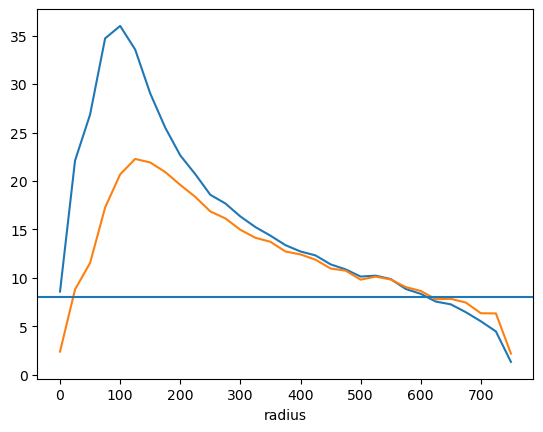

In [79]:
wsp_storm_radius.plot()
wsp_storm_radius_ai.plot()
plt.axhline(8)

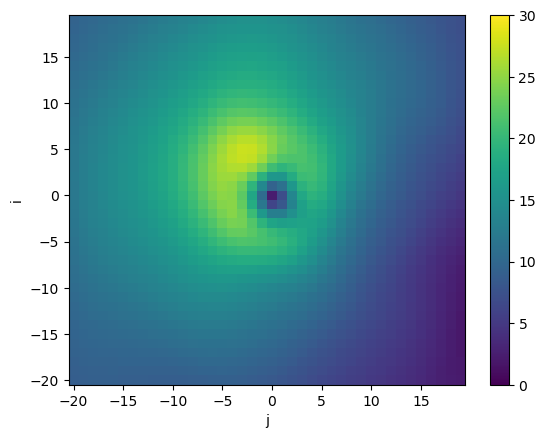

In [74]:
(wsp_storm_ai).plot(vmin=0,vmax=30)

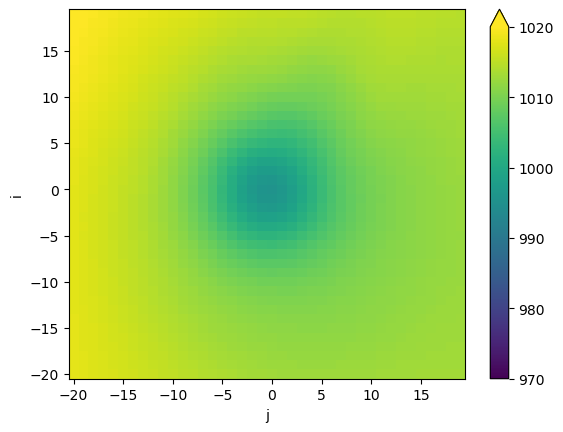

In [ ]:
(msl_storm_ai*0.01).plot(vmin=970,vmax=1020)

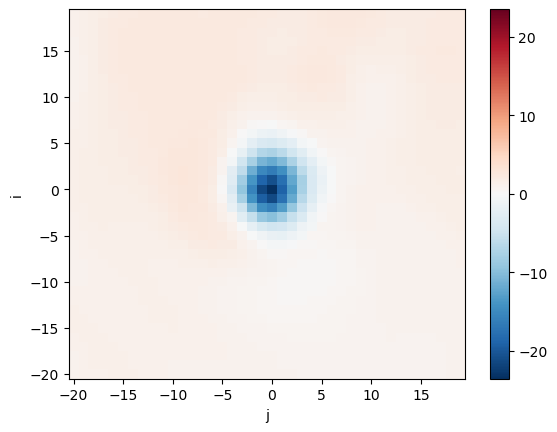

In [ ]:
((msl_storm - msl_storm_ai)*0.01).plot()

# PGW approach

In [29]:
#we want to run our model for different dates
t0_i = datetime.datetime(2018,9,9,0)
t0_f = datetime.datetime(2018,9,12,18)
delta_h = 6
# number of forecast steps
num_steps = 4 * 15 # 6h intervals

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

models = ['awi-cm-1-1-mr', 'bcc-csm2-mr', 'cams-csm1-0', 'canesm5-1', 'cas-esm2-0', 'cmcc-cm2-hr4', \
          'cmcc-cm2-sr5', 'cmcc-esm2', 'ec-earth3-cc', 'ec-earth3-veg-lr', 'ec-earth3-veg','ec-earth3']

In [30]:
def load_data_deltas(var, init_times, models):
    var_inits_model = []
    for model in models:
        print(model)
        var_inits = []
        for t0 in init_times:
            yyyymmddhh = t0.strftime('%Y%m%d%H')    
            file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_PGW_{model}_{yyyymmddhh}.nc'
            ds = xr.open_dataset(file)[var]
            var_inits.append(ds)
        var_inits_model.append(xr.concat(var_inits, dim='init_time'))
    merged_dataset = xr.concat(var_inits_model, dim='model')

    return merged_dataset.assign_coords(init_time=init_times,model=models)

msl_pwg = load_data_deltas('msl',init_times, models)
tcwv_pwg = load_data_deltas('tcwv',init_times, models)
v100_pwg = load_data_deltas('v100',init_times, models)
u100_pwg = load_data_deltas('u100',init_times, models)

awi-cm-1-1-mr


bcc-csm2-mr
cams-csm1-0
canesm5-1
cas-esm2-0
cmcc-cm2-hr4
cmcc-cm2-sr5
cmcc-esm2
ec-earth3-cc
ec-earth3-veg-lr
ec-earth3-veg
ec-earth3
awi-cm-1-1-mr
bcc-csm2-mr
cams-csm1-0
canesm5-1
cas-esm2-0
cmcc-cm2-hr4
cmcc-cm2-sr5
cmcc-esm2
ec-earth3-cc
ec-earth3-veg-lr
ec-earth3-veg
ec-earth3
awi-cm-1-1-mr


FileNotFoundError: [Errno 2] No such file or directory: '/home/bernatj/Data/ai-forecasts/fcst/2018090900/v100_fcnv2_PGW_awi-cm-1-1-mr_2018090900.nc'

In [31]:
tcwv_pwg

<xarray.DataArray 'tcwv' (model: 12, init_time: 16, time: 76, lat: 721,
                          lon: 1440)> Size: 61GB
array([[[[[  6.5106125 ,   6.5105762 ,   6.510538  , ...,
             6.5108776 ,   6.51071   ,   6.510542  ],
          [  6.512642  ,   6.5125866 ,   6.5125313 , ...,
             6.512903  ,   6.512724  ,   6.5125456 ],
          [  6.446311  ,   6.4462395 ,   6.446167  , ...,
             6.4465675 ,   6.4463787 ,   6.44619   ],
          ...,
          [  0.18306732,   0.18309212,   0.183115  , ...,
             0.18293953,   0.1829338 ,   0.18293   ],
          [  0.18747902,   0.18750381,   0.18752861, ...,
             0.18735695,   0.1873455 ,   0.18733406],
          [  0.19970322,   0.19972801,   0.19975281, ...,
             0.19958496,   0.1995678 ,   0.19955063]],

         [[  6.0427074 ,   6.0427074 ,   6.0427074 , ...,
             6.0426054 ,   6.0426054 ,   6.0427074 ],
          [  5.5879593 ,   5.595046  ,   5.5854397 , ...,
             5.579197  ,   5.581998  ,   5.584035  ],
          [  5.393779  ,   5.392928  ,   5.3961706 , ...,
             5.4051237 ,   5.4029474 ,   5.403246  ],
...
          [-22.333395  , -22.34101   , -22.34654   , ...,
           -22.340155  , -22.329412  , -22.34846   ],
          [-24.959627  , -24.936884  , -24.941954  , ...,
           -24.94668   , -24.937979  , -24.947191  ],
          [-25.91273   , -25.920649  , -25.920668  , ...,
           -25.911089  , -25.916521  , -25.915274  ]],

         [[  8.366031  ,   8.366031  ,   8.358006  , ...,
             8.3657055 ,   8.3687935 ,   8.363918  ],
          [  7.994975  ,   7.999262  ,   7.9873295 , ...,
             8.017142  ,   8.018566  ,   8.002288  ],
          [  7.827361  ,   7.8645525 ,   7.871027  , ...,
             7.8518925 ,   7.844919  ,   7.8668213 ],
          ...,
          [-19.837988  , -19.825933  , -19.826605  , ...,
           -19.84392   , -19.820898  , -19.831045  ],
          [-22.349043  , -22.345991  , -22.332586  , ...,
           -22.363958  , -22.36429   , -22.360655  ],
          [-23.312643  , -23.316439  , -23.31035   , ...,
           -23.303068  , -23.313448  , -23.318972  ]]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon        (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 608B 2018-09-09 ... 2018-09-27T18:00:00
  * init_time  (init_time) datetime64[ns] 128B 2018-09-09 ... 2018-09-12T18:0...
  * model      (model) <U16 768B 'awi-cm-1-1-mr' 'bcc-csm2-mr' ... 'ec-earth3'

In [32]:
#region and time to calculate the trajectories
lat_slice=slice(36,22)
lon_slice=slice(275,320)
time_slice=slice('2018-09-09', '2018-09-15')

# Assuming data is your 2D array
msl_pgw_area = msl_pwg.sel(lat=lat_slice,lon=lon_slice, time=time_slice)
latitudes = msl_pgw_area.lat
longitudes = msl_pgw_area.lon

lat_track_list_pgw = []
lon_track_list_pgw = []
min_track_list_pgw = []

for init in init_times:
    for model in models:
        print(init)
        data = msl_pgw_area.sel(init_time=init,model=model).data
        lat_track, lon_track, min_track = calculate_trajectory(data, latitudes, longitudes, threshold_distance=10, threshold_data_value=102500, neighborhood_size=100)
        lat_track_list_pgw.append(lat_track)
        lon_track_list_pgw.append(lon_track) 
        min_track_list_pgw.append(min_track) 

2018-09-09 00:00:00
2018-09-09 00:00:00
break: distance 40.56245184896988, threshold: 100441.0625
2018-09-09 00:00:00
break: distance 39.714606884621176, threshold: 100441.0625
2018-09-09 00:00:00
break: distance 40.48533685175412, threshold: 100441.0625
2018-09-09 00:00:00
break: distance 40.31904016714684, threshold: 100441.0625
2018-09-09 00:00:00
break: distance 19.560802642018555, threshold: 100441.0625
2018-09-09 00:00:00
break: distance 39.01041527592343, threshold: 100441.0625
2018-09-09 00:00:00
break: distance 39.421599409460796, threshold: 100441.0625
2018-09-09 00:00:00
2018-09-09 00:00:00
break: distance 39.13837630765998, threshold: 100441.0625
2018-09-09 00:00:00
2018-09-09 00:00:00
2018-09-09 06:00:00
2018-09-09 06:00:00
break: distance 41.027429848821875, threshold: 100242.125
2018-09-09 06:00:00
break: distance 40.23835235195398, threshold: 100242.125
2018-09-09 06:00:00
break: distance 40.87175063537161, threshold: 100242.125
2018-09-09 06:00:00
break: distance 40.90

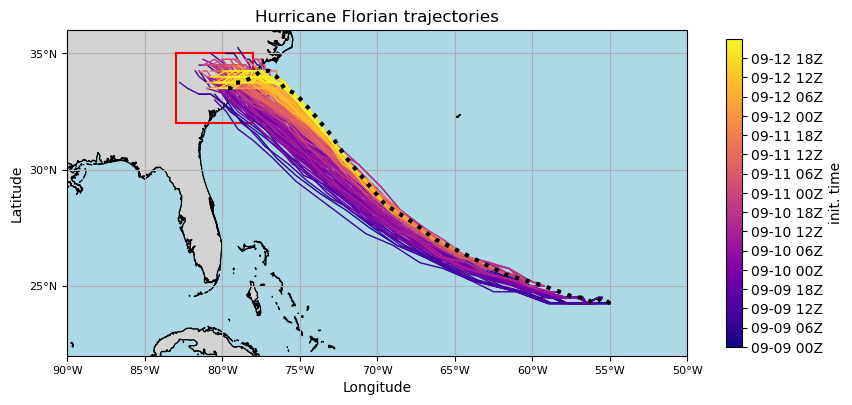

In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

# Create subplots with shared y-axis and manually share x-axis
f, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Assuming Natl is your xarray dataset containing latitude and longitude coordinates
# minima_indices is the indices of the minima obtained earlier
latitudes = msl['lat'].values
longitudes = msl['lon'].values

ax.set_aspect(1.5)
ax.coastlines(lw=0.8, color='k')  
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Fill land area
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')  # Fill ocean area



nLons = np.arange(-180, 180, 5)
nLats = np.arange(20, 41, 5)
ax.set_xticks(nLons, crs=ccrs.PlateCarree())
ax.set_yticks(nLats, crs=ccrs.PlateCarree())
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylim([22, 36])
ax.set_xlim([-90, -50])

# format the ticks as e.g 60°W
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Hurricane Florian trajectories')
ax.grid(True)

# Define a colormap that starts from blue and gradually moves towards red
cmap = plt.get_cmap('plasma')

# Normalize initialization times to range from 0 to 1
norm = plt.Normalize(0, len(init_times*12))

for i,_ in enumerate(lat_track_list_pgw):
    # Extract latitude and longitude values corresponding to minima_indices
    color = cmap(norm(i))
    ax.plot(lon_track_list_pgw[i], lat_track_list_pgw[i], lw=1.0, color=color, transform=ccrs.PlateCarree(), zorder=100)

ax.plot(lon_track_era5, lat_track_era5, lw=3.0, color='k', ls=':', transform=ccrs.PlateCarree(), zorder=101)


# Create a colorbar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="init. time", shrink=0.4)
cbar.set_ticks(np.arange(0, len(init_times)*12,12))

# Format the init_times to show only MM-DD HHUTC
init_time_labels = [time.strftime('%m-%d %HZ') for time in init_times]
cbar.set_ticklabels(init_time_labels)

lon_min, lon_max = -83, -78
lat_min, lat_max = 32, 35

ax.plot([lon_min, lon_max], [lat_min, lat_min], color='red', transform=ccrs.PlateCarree())
ax.plot([lon_max, lon_max], [lat_min, lat_max], color='red', transform=ccrs.PlateCarree())
ax.plot([lon_max, lon_min], [lat_max, lat_max], color='red', transform=ccrs.PlateCarree())
ax.plot([lon_min, lon_min], [lat_max, lat_min], color='red', transform=ccrs.PlateCarree())



f.savefig(f'Hurricane_Florence_2018_Tracks_different_inits_and_models_pgw.pdf')
f.savefig(f'Hurricane_Florence_2018_Tracks_different_inits_and_models_pgw.png')

In [34]:
#average of all te trajectories:
lat_track_list_pgw_mean = []
lon_track_list_pgw_mean = []
min_track_list_pgw_mean = []

for i in range(0,len(lat_track_list_pgw),12):
  
  lat_track_list_pgw_mean.append([sum(x)/12 for x in zip(*lat_track_list_pgw[i:i+12])])
  lon_track_list_pgw_mean.append([sum(x)/12 for x in zip(*lon_track_list_pgw[i:i+12])])
  min_track_list_pgw_mean.append([sum(x)/12 for x in zip(*min_track_list_pgw[i:i+12])])

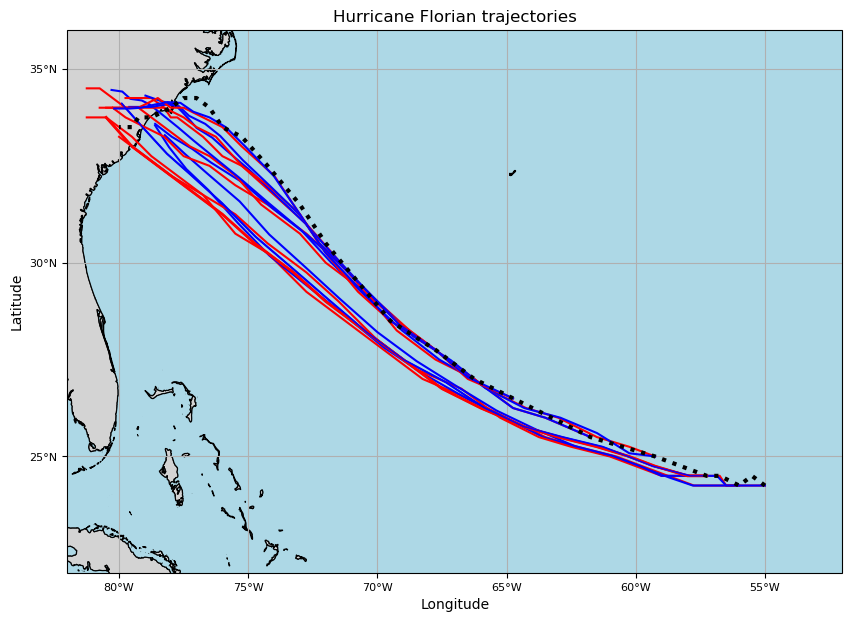

In [35]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Create subplots with shared y-axis and manually share x-axis
f, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Assuming Natl is your xarray dataset containing latitude and longitude coordinates
# minima_indices is the indices of the minima obtained earlier
latitudes = msl['lat'].values
longitudes = msl['lon'].values

ax.set_aspect(1.5)
ax.coastlines(lw=0.8, color='k') 
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Fill land area
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')  # Fill ocean area


nLons = np.arange(-180, 180, 5)
nLats = np.arange(20, 41, 5)
ax.set_xticks(nLons, crs=ccrs.PlateCarree())
ax.set_yticks(nLats, crs=ccrs.PlateCarree())
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylim([22, 36])
ax.set_xlim([-82, -52])

# format the ticks as e.g 60°W
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Hurricane Florian trajectories')
ax.grid(True)


for i in range(0,15,2):

    ax.plot(lon_track_list[i], lat_track_list[i], lw=1.5, color='red', transform=ccrs.PlateCarree(), zorder=100)
    ax.plot(lon_track_list_pgw_mean[i], lat_track_list_pgw_mean[i], lw=1.5, color='blue', transform=ccrs.PlateCarree(), zorder=100)

ax.plot(lon_track_list[4], lat_track_list[4], lw=2.0, color='red', transform=ccrs.PlateCarree(), zorder=100)
ax.plot(lon_track_list_pgw_mean[4], lat_track_list_pgw_mean[4], lw=1.0, color='blue', transform=ccrs.PlateCarree(), zorder=100)

ax.plot(lon_track_era5, lat_track_era5, lw=3.0, color='k', ls=':', transform=ccrs.PlateCarree(), zorder=101)



12
13
14
15


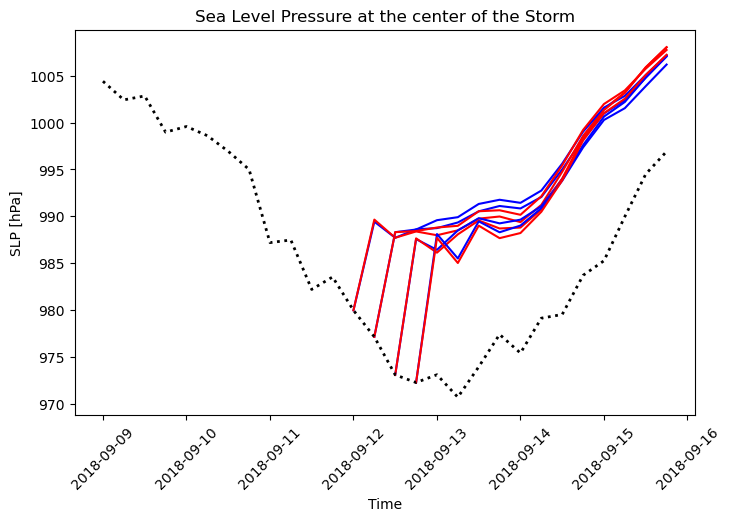

In [36]:
#evolution of pressure at along the track
f, ax = plt.subplots(1, 1, figsize=(8,5))

# Define a colormap that starts from blue and gradually moves towards red
cmap = plt.get_cmap('plasma')

# Normalize initialization times to range from 0 to 1
norm = plt.Normalize(0, len(init_times))

for i in range(12,16):
    print(i)
    # Extract latitude and longitude values corresponding to minima_indices
    color = cmap(norm(i))
    plt.plot(msl_pwg.time.values[i:i+len(min_track_list_pgw_mean[i])], np.array(min_track_list_pgw_mean[i])*0.01 , color='b')
    plt.plot(msl_pwg.time.values[i:i+len(min_track_list[i])], np.array(min_track_list[i])*0.01 , color='r')

plt.plot(msl_era5_area.time.values[0:len(min_track_era5)], np.array(min_track_era5)*0.01, color='k', lw=2, ls=':')


plt.xticks(rotation=45)


# Add labels and title
plt.xlabel('Time')
plt.ylabel('SLP [hPa]')
plt.title('Sea Level Pressure at the center of the Storm')

# Show the plot
plt.show()

#f.savefig(f'Hurricane_Florence_2018_SLP_Minimum_evolution_different inits.pdf')


In [80]:
#let's define a box in the area where to average the precipitable water
lat_slice = slice(35,32)
lon_slice = slice(360-83,360-78)
tcwv_pwg_box = tcwv_pwg.sel(lat=lat_slice,lon=lon_slice).mean('lat').mean('lon').sel(time=slice('09-09-2018','17-09-2018'))

In [81]:
tcwv_era5_box = tcwv_era5.sel(lat=lat_slice,lon=lon_slice).mean('lat').mean('lon').sel(time=slice('09-09-2018','17-09-2018'))

In [82]:
tcwv_ai_box = tcwv.sel(lat=lat_slice,lon=lon_slice).mean('lat').mean('lon').sel(time=slice('09-09-2018','17-09-2018'))

In [96]:
# Plot the average
ens_mean = tcwv_ai_box.mean('init_time')  
ens_max = tcwv_ai_box.quantile(0.95,'init_time') 
ens_min = tcwv_ai_box.quantile(0.05,'init_time') 
ens_p90 = tcwv_ai_box.quantile(0.75,'init_time') 
ens_p10 = tcwv_ai_box.quantile(0.25,'init_time') 

ens_pgw_mean = tcwv_pwg_box.mean(['init_time','model'])  
ens_pgw_max = tcwv_pwg_box.quantile(0.95,['init_time','model']) 
ens_pgw_min = tcwv_pwg_box.quantile(0.05,['init_time','model']) 
ens_pgw_p90 = tcwv_pwg_box.quantile(0.75,['init_time','model']) 
ens_pgw_p10 = tcwv_pwg_box.quantile(0.25,['init_time','model']) 

Text(0.5, 1.0, '')

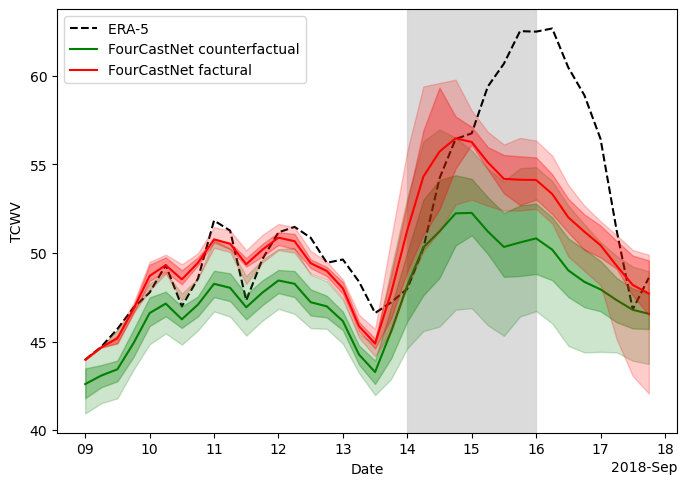

In [97]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(8, 5.5))

# Plot t2m_era5_max_iberia_avg
tcwv_era5_box.plot(ax=ax, label='ERA-5 ', color='k', linestyle='--')

# Plot t2m_ai_max_iberia_avg
ens_pgw_mean.plot(ax=ax, label='FourCastNet counterfactual', color='g', linestyle='-', zorder=102)
ax.fill_between(ens_pgw_min['time'], ens_pgw_min, ens_pgw_max, color='g', alpha=0.2, zorder=101)
ax.fill_between(ens_pgw_min['time'], ens_pgw_p10, ens_pgw_p90, color='g', alpha=0.3, zorder=100)
#ens_max.plot(ax=ax, color='g', linestyle=':', zorder=102)
#ens_min.plot(ax=ax, color='g', linestyle=':', zorder=102)

#factual world
ens_mean.plot(ax=ax, label='FourCastNet factural', color='r', linestyle='-', zorder=202)
ax.fill_between(ens_min['time'], ens_min, ens_max, color='r', alpha=0.2, zorder=201)
ax.fill_between(ens_min['time'], ens_p10, ens_p90, color='r', alpha=0.3, zorder=200)
#ens_max_fac[0:15].plot(ax=ax, color='r', linestyle=':', zorder=102)
#ens_min_fac[0:15].plot(ax=ax, color='r', linestyle=':', zorder=102)


# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-09-14')
aug_7 = pd.to_datetime('2018-09-16')

# Add a filled background between the vertical lines
ax.axvspan(aug_1, aug_7, color='lightgray', alpha=0.8)

# Add legend
ax.legend(fontsize=10)

#ax.set_ylim([25,35])

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('TCWV')
ax.set_title('')

#plt.savefig('plot_HW2018_atribution_12CMIP6_deltas_16inits_Iberian_landmean_2.pdf')
